In [1]:
import os

import scipy
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = io.loadmat("data/data.mat")
print("\nloaded data!")
fields = "X_test", "X", "y"
for field in fields:
    print(field, data[field].shape)


loaded data!
X_test (497, 12)
X (6000, 12)
y (6000, 1)


In [3]:
# Utilitarian functions.

# Random seed.
random = np.random.RandomState(15)

# Normalizing the feature.
def normalize_column(X):
    norm_X = np.zeros(X.shape)
    for i in range(X.shape[1]):
        #norm_X[:, i] = X[:, i] /(np.linalg.norm(X[:, i]))
        #norm_X[:, i] = (X[:, i] - np.mean(X[:, i]))/(np.std(X[:, i]))
        norm_X[:, i] = (X[:, i] - np.mean(X[:, i]))/(np.std(X[:, i]))
    return norm_X

# Split training and validation.
def split(data, labels, val_size):
    num_items = len(data)
    assert num_items == len(labels)
    assert val_size >= 0
    if val_size < 1.0:
        val_size = int(num_items * val_size)
    train_size = num_items - val_size
    idx = random.permutation(num_items)
    data_train = data[idx][:train_size]
    label_train = labels[idx][:train_size]
    data_val = data[idx][train_size:]
    label_val = labels[idx][train_size:]
    return data_train, data_val, label_train, label_val

# Prediction and accuracy function.
def predict(X, w, theta):
    y_predicted = scipy.special.expit(np.dot(X, w))
    pred_class = [1 if i > theta else 0 for i in y_predicted]
    return pred_class

def accuracy(y_true, y_pred):
    n = len(y_true)
    compare = [1 if y_true[i]==y_pred[i] else 0 for i in range(n)]
    return sum(compare)/len(compare)

# Helper function to safe the kaggle data.
def results_to_csv(y_test, name):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv(name + '.csv', index_label='Id')


In [4]:
# Loading data.
wine = io.loadmat("data/data.mat")
wine_X, wine_y = wine['X'], wine['y']
wine_test_X = wine['X_test']

# Normalizing each feature.
wine_X = normalize_column(wine_X)
wine_test_X = normalize_column(wine_test_X)
#print(wine_X.shape[0])

# Add a fictitious dimention (bias) to all the design matrices.
train_bias = np.ones((wine_X.shape[0], 1))
test_bias = np.ones((wine_test_X.shape[0], 1))
wine_X = np.hstack((wine_X, train_bias))
wine_test_X = np.hstack((wine_test_X, test_bias));

In [5]:
# Split to 5000 train data and 1000 validation data.
wine_train_X, wine_val_X, wine_train_y, wine_val_y = \
        split(wine_X, wine_y, 1000)

# Sanity checks for the data.
#print("Shapes of training:%d, val:%d, and testing %d"
#     (int(wine_train_X.shape[0]),int(wine_val_X.shape[0]),int(wine_test_X.shape[0])))
print(wine_train_X.shape)
print(wine_val_X.shape)
print(wine_test_X.shape)
print(wine_train_X[0])

(5000, 13)
(1000, 13)
(497, 13)
[-0.63084402 -0.90925812  0.69791319 -0.53539797 -0.68179644  0.08365086
 -0.58230741 -1.29530507  0.51075352 -0.81171806  1.01319702  0.20079359
  1.        ]


In [7]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))


def L2_CrossEntropy(y, w, X, reg):
    A = y * np.log(scipy.special.expit(X @ w))
    B = (1 - y) * np.log(1 - scipy.special.expit(X @ w))
    return reg*(np.linalg.norm(w)**2 - w[-1]**2)/2 + np.sum(- A - B)

def plot_loss(loss, method):
    plt.figure(figsize=(12, 9))
    plt.xlabel('Number of Interation')
    plt.ylabel('Loss')
    plt.title('Loss/Iteration for' + ' ' + method)
    x = [i+1 for i in range(len(loss))]
    plt.plot(x, loss)
    plt.show;

def SGD_step(y, w, X, reg, lr, n_iter):
    loss = []
    for i in range(n_iter):
        idx = np.random.randint(y.size)
        #print(idx)
        loss.append(L2_CrossEntropy(y, w, X, reg))
        s = scipy.special.expit(np.dot(X[idx, :].reshape(1, 13), w))
        #print(s.shape)
        dw = reg * w - (X[idx, :].T.reshape(13, 1) * (y[idx] - s))
        w = w - (lr/(i+1)) * dw

    return w, loss

<font size='3.6'>**3(1) Batch Gradient Descent Update**<br>
    <br>
    The update rule of $w$ is $$w^{(t+1)} = w^{(t)} - \epsilon (\lambda w^{(t)} - X^{T}(y - s(Xw)))$$

<font size='3.6'>**3(2) Batch Gradient Descnet Code**<br>
    <br>
    Below's the code for BGD. After wirting the code, I use a grid search to get a sense of what kind of combination works best on the Batch Gradient Descent.

In [18]:
# Batch Gradient Descent with Logistic Regression.
def BGD(y, w, X, reg, lr, n_iter):
    loss = []
    for i in range(n_iter):
        loss.append(L2_CrossEntropy(y, w, X, reg))
        s = scipy.special.expit(np.matmul(X, w))
        dw = reg * w - np.matmul(X.T, (y - s))
        w = w - lr * dw/y.size

    return w, loss

In [8]:
w_best = np.random.randn(wine_train_X.shape[1]).reshape((-1, 1))
w_init = np.zeros(wine_train_X.shape[1]).reshape((-1, 1))
acc_best = 0
loss_best = 500000
for reg in [2, 1, 0.5, 0.1, 1e-2, 1e-3]:
    for lr in [1e-1, 2e-2, 5e-2, 1e-2, 1e-3]:
        w, _ = BGD(wine_train_y, w_init, wine_train_X, reg, lr, 1000)
        train_pred = predict(wine_train_X, w, 0.5)
        val_pred = predict(wine_val_X, w, 0.5)
        train_acc = accuracy(wine_train_y, train_pred)
        val_acc = accuracy(wine_val_y, val_pred)
        print('reg %f, lr %f, train_acc %f, val_acc %f' %(reg, lr, train_acc, val_acc))

reg 2.000000, lr 0.100000, train_acc 0.992800, val_acc 0.988000
reg 2.000000, lr 0.020000, train_acc 0.989400, val_acc 0.986000
reg 2.000000, lr 0.050000, train_acc 0.992200, val_acc 0.988000
reg 2.000000, lr 0.010000, train_acc 0.986600, val_acc 0.982000
reg 2.000000, lr 0.001000, train_acc 0.968600, val_acc 0.965000
reg 1.000000, lr 0.100000, train_acc 0.992800, val_acc 0.988000
reg 1.000000, lr 0.020000, train_acc 0.989400, val_acc 0.986000
reg 1.000000, lr 0.050000, train_acc 0.992200, val_acc 0.988000
reg 1.000000, lr 0.010000, train_acc 0.986600, val_acc 0.982000
reg 1.000000, lr 0.001000, train_acc 0.968600, val_acc 0.965000
reg 0.500000, lr 0.100000, train_acc 0.992800, val_acc 0.988000
reg 0.500000, lr 0.020000, train_acc 0.989400, val_acc 0.986000
reg 0.500000, lr 0.050000, train_acc 0.992200, val_acc 0.988000
reg 0.500000, lr 0.010000, train_acc 0.986600, val_acc 0.982000
reg 0.500000, lr 0.001000, train_acc 0.968600, val_acc 0.965000
reg 0.100000, lr 0.100000, train_acc 0.9

<font size=3.3> <br> Seems like 0.1 and 0.1 is a decent combination.

training accuracy: 0.989800, validation accuracy: 0.989000


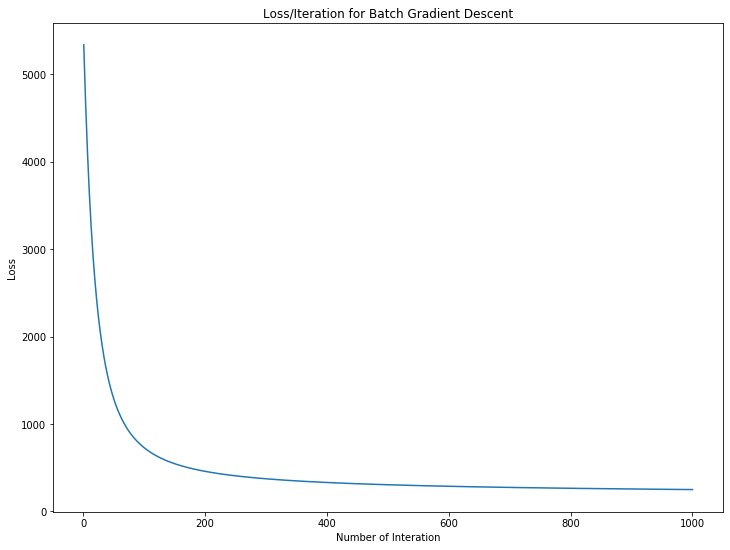

In [12]:
# Initialize w as a zero vector with length of feature number.
random = np.random.RandomState(15)
w_init = np.random.randn(wine_train_X.shape[1]).reshape((-1, 1))
w_out, loss = BGD(wine_train_y, w_init, wine_train_X, 0.1, 0.1, 1000)
train_acc = accuracy(wine_train_y, predict(wine_train_X, w_out, 0.5))
val_acc = accuracy(wine_val_y, predict(wine_val_X, w_out, 0.5))
print("training accuracy: %f, validation accuracy: %f" %(train_acc, val_acc))
plot_loss(loss, 'Batch Gradient Descent')

<font size='3.6'>**3(3) Stochastic Gradient Descent (SGD) Update**<br>
    <br>
    The update rule of $w$ is $$w^{(t+1)} = w^{(t)} - \epsilon (\lambda w^{(t)} - X^{T}_{i}(y_{i} - s(X_{i}w)))$$

<font size='3.6'>**3(4) Stochastic Gradient Descent Code**<br>
    <br>
    Below's the stochastic gradient descent code. 
   <br><br>
    
   Comparing the two graph of BGD and SGD, we see that BGD converges **faster** than SGD. BGD uses around 200 iteration to converge, whearas SGD uses more than that number and also has a high oscillations.

In [19]:
def SGD(y, w, X, reg, lr, n_iter):
    loss = []
    for i in range(n_iter):
        idx = np.random.randint(y.size)
        #print(idx)
        loss.append(L2_CrossEntropy(y, w, X, reg))
        s = scipy.special.expit(np.dot(X[idx, :].reshape(1, 13), w))
        #print(s.shape)
        dw = reg * w - (X[idx, :].T.reshape(13, 1) * (y[idx] - s))
        w = w - lr * dw

    return w, loss

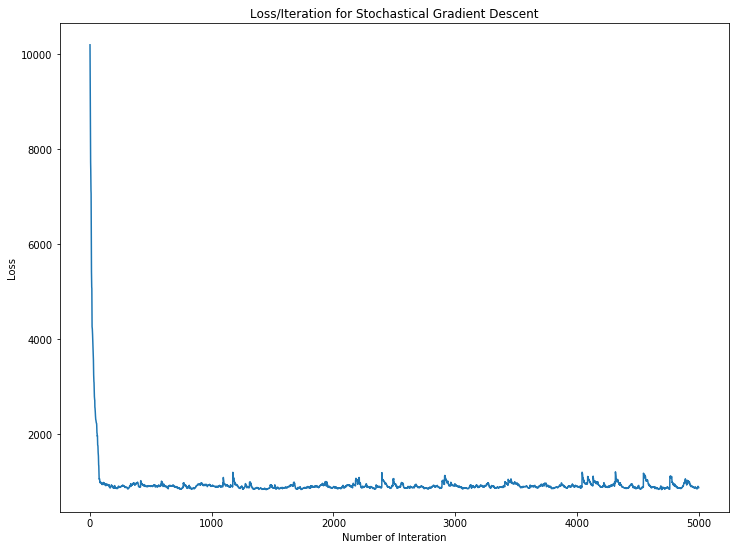

In [15]:
random = np.random.RandomState(15)
w_init = np.random.randn(wine_train_X.shape[1]).reshape((-1, 1))
sgd_w_out, sgd_loss = SGD(wine_train_y, w_init, wine_train_X, 0.1, 0.1, 5000)
plot_loss(sgd_loss, 'Stochastical Gradient Descent')

<font size=3.6><br> We can see obvious oscillations. We can fix this a little bit by using a smaller learning rate.

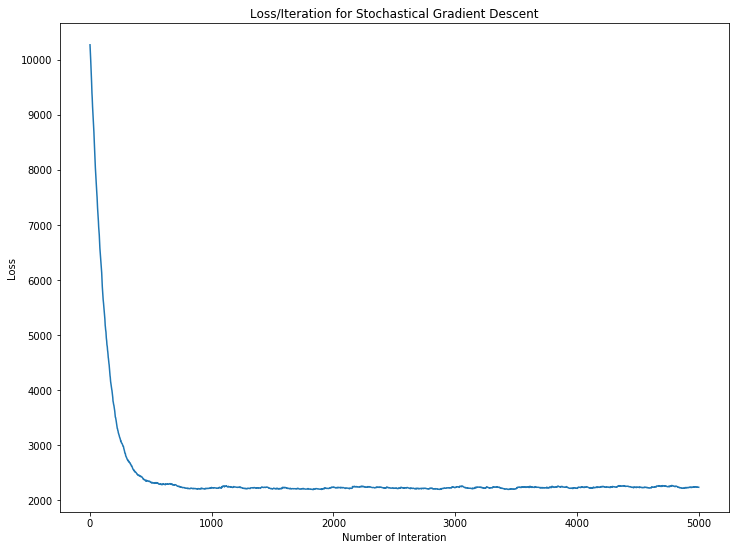

In [17]:
random = np.random.RandomState(15)
w_init = np.random.randn(wine_train_X.shape[1]).reshape((-1, 1))
sgd_w_out, sgd_loss = SGD(wine_train_y, w_init, wine_train_X, 1, 0.005, 5000)
plot_loss(sgd_loss, 'Stochastical Gradient Descent')

<font size='3.6'>**3(5) Step Stochastic Gradient Descent Code**<br>
    <br> The code's below for step stochastic gradient descent.

   <br> The convergence is not as fast as the regular SGD but the curve is in general much more smooth. The changing learning rate makes the training more stable.

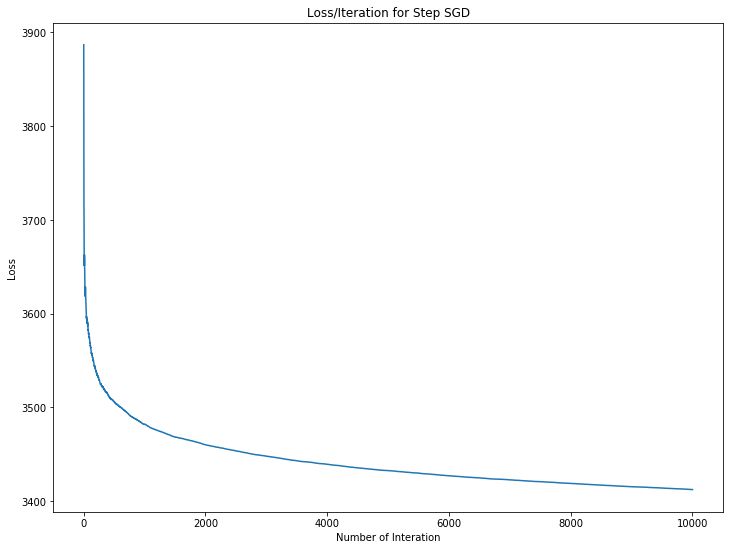

In [128]:
random = np.random.RandomState(15)
w_init = np.random.randn(wine_train_X.shape[1]).reshape((-1, 1))
step_w_out, step_loss = SGD_step(wine_train_y, w_init, wine_train_X, 0.1, 0.1, 10000)
plot_loss(step_loss, 'Step SGD')

<font size='3.6'>**3(6) Kaggle**<br>
    
<br> Since the training set is relatively small, I use the $W_{out}$ from Batch Gradient Descent.

<br> Notice that in my L2_CrossEntropy Loss, I do not penalize the bias term of the $W_{out}$. This boost my validation accuracy a little bit.

In [26]:
train_acc = accuracy(wine_train_y, predict(wine_train_X, w_out, 0.5))
val_acc = accuracy(wine_val_y, predict(wine_val_X, w_out, 0.5))
print(train_acc)
print(val_acc)

0.9934
0.989


In [317]:
test_pred = np.array(predict(wine_test_X, w_out, 0.5))
results_to_csv(test_pred, 'first')